In [126]:
import cufflinks as cf
import numpy as np
import pandas as pd

cf.go_offline()

In [127]:
def get_data_V2(category='confirmed'):
    df = (
        pd.read_csv(f'csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_{category}_global.csv')
        .rename(columns={'Province/State': 'state', 'Country/Region': 'country', 'Lat': 'latitude', 'Long': 'long'})
        .set_index(['state', 'country'])
        .drop(columns=['latitude', 'long'])
    )
    df.columns = [pd.Timestamp(col) for col in df.columns]
    df = df.reset_index().drop(columns=['state']).groupby('country').sum().transpose()
    df.index.name = 'date'
    df.columns = list(df.columns)

    return df

In [128]:
def get_globe(df, name, threshold=None):
    globe = df.drop(columns=['China']).sum(axis=1)
    if threshold:
        globe[globe<threshold]=np.nan
    globe = globe.apply(np.log)
    globe.name=name
    globe = globe.dropna().reset_index()
    return globe

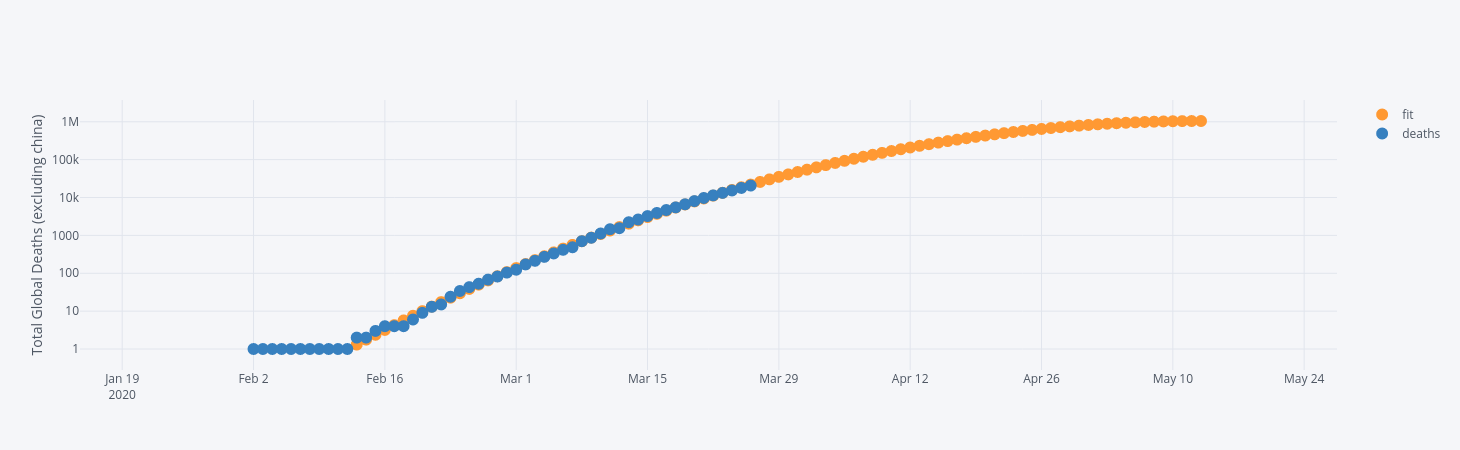

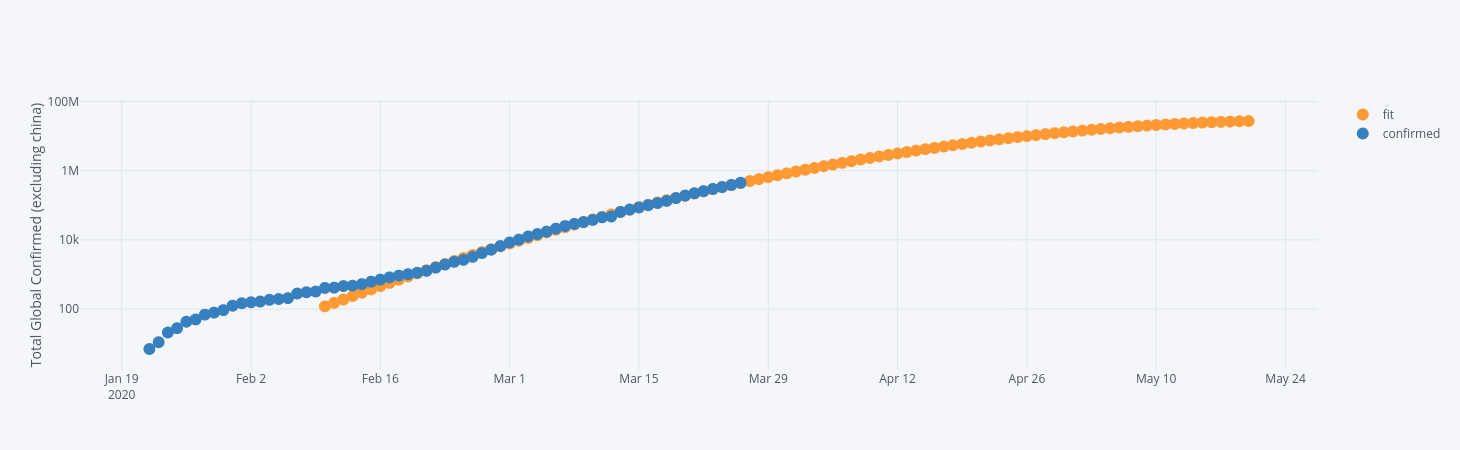

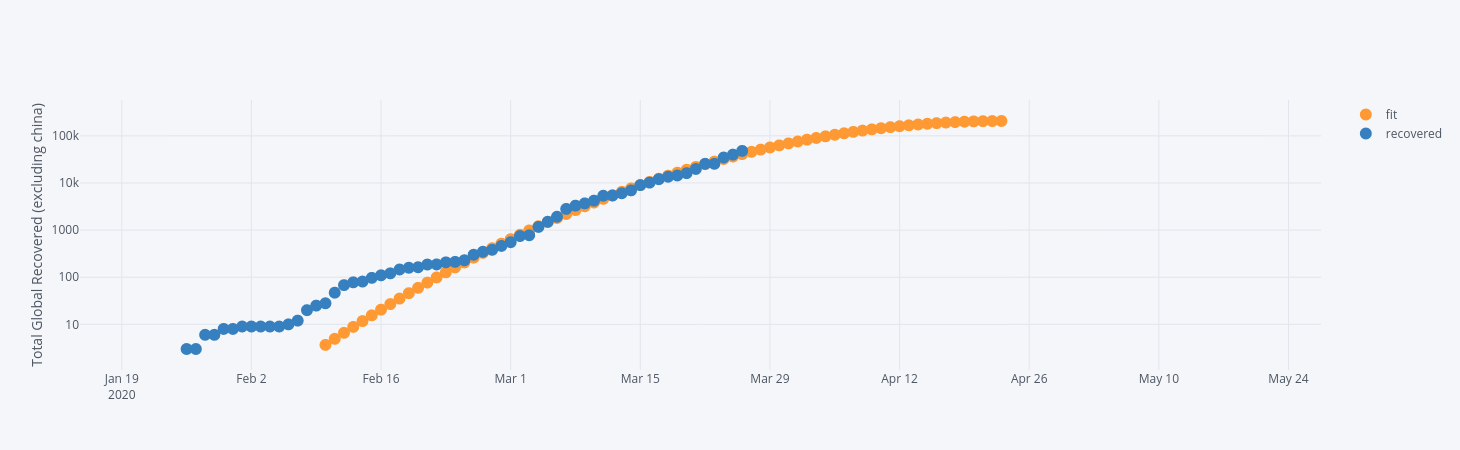

In [129]:
category = 'deaths'
threshold_for_model = {'recovered': 300, 'confirmed': 1000, 'deaths': 10}

def generate_model(category):
    df = get_data_V2(category)
    globe = get_globe(df, category, threshold=threshold_for_model[category])
    x = globe['date'].astype(int)
    c, b, a = np.polyfit(x, globe[category], 2)
    x = pd.Series(pd.date_range('2020-02-10', '2020-05-20')).astype(int)
    fit = a + b*x + c*x*x
    extra = pd.DataFrame(data=fit, columns=['fit'])
    extra['date'] = pd.to_datetime(x)
    extra = extra.set_index('date')

    globe = get_globe(df, category)
    fit = pd.concat((globe.set_index('date'), extra), axis=1)
    fit.loc[(fit<0)['fit'], 'fit'] = np.nan
    fit.loc[(fit.diff()<0)['fit'], 'fit'] = np.nan
    fit.apply(np.exp)[['fit', category]].iplot(logy=True, yTitle=f'Total Global {category.capitalize()} (excluding china)', mode='markers')
    
generate_model('deaths')
generate_model('confirmed')
generate_model('recovered')

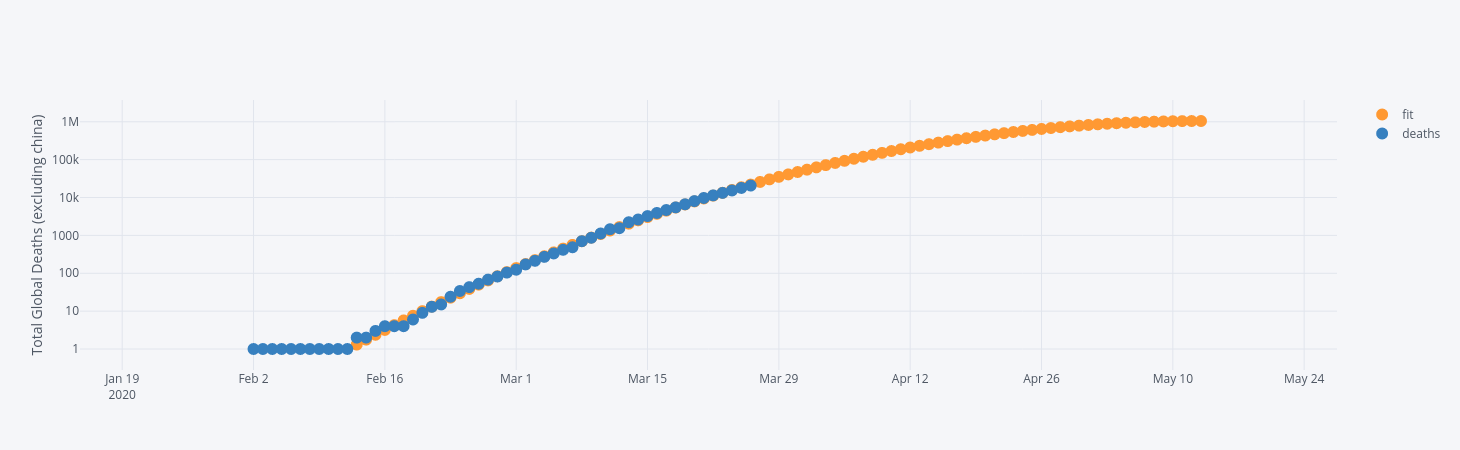

In [195]:
category = 'deaths'
df = get_data_V2(category)
globe = get_globe(df, category, threshold=threshold_for_model[category])
x = globe['date'].astype(int)
y = globe[category]
c, b, a = np.polyfit(x, y, 2)
x2 = pd.Series(pd.date_range('2020-02-10', '2020-05-20')).astype(int)
fit = a + b*x2 + c*x2*x2
extra = pd.DataFrame(data=fit, columns=['fit'])
extra['date'] = pd.to_datetime(x2)
extra = extra.set_index('date')

globe = get_globe(df, category)
fit = pd.concat((globe.set_index('date'), extra), axis=1)
fit.loc[(fit<0)['fit'], 'fit'] = np.nan
fit.loc[(fit.diff()<0)['fit'], 'fit'] = np.nan
fit.apply(np.exp)[['fit', category]].iplot(logy=True, yTitle=f'Total Global {category.capitalize()} (excluding china)', mode='markers')

/home/chris/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning:

invalid value encountered in sqrt

/home/chris/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning:

invalid value encountered in sqrt

/home/chris/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning:

The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead

/home/chris/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning:

The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead

/home/chris/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning:

The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead



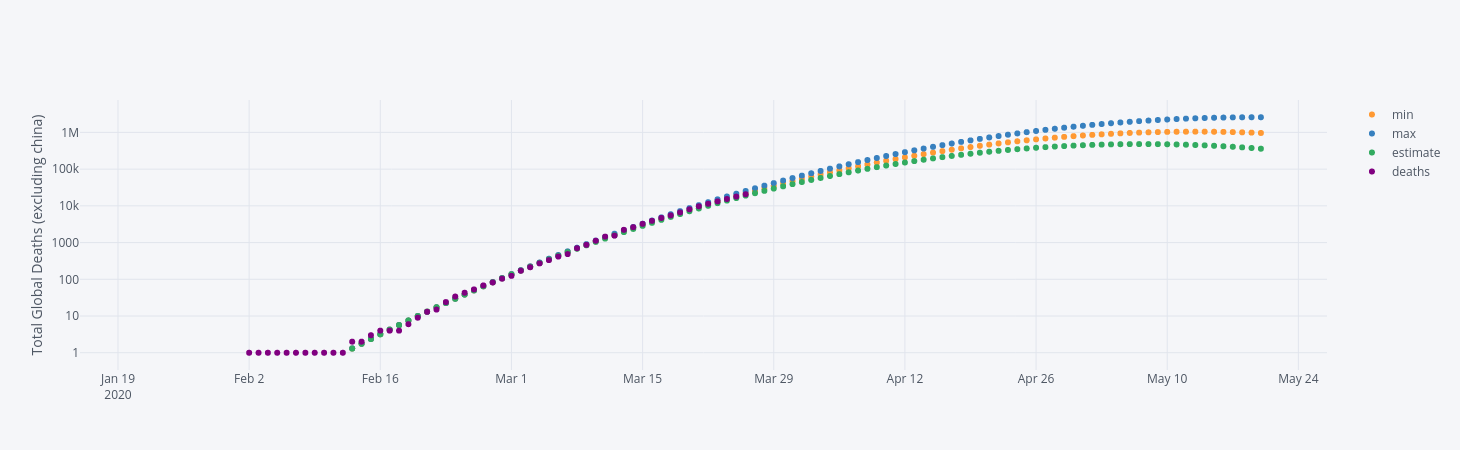

In [131]:
n_sigma = 1

x0 = min(x)
delta = max(x) - min(x)
x = (x-x0)/delta
x2 = (x2-x0)/delta

coeff, cov = np.polyfit(x, y, 2, cov=True)
coeff_min = coeff - n_sigma*np.sqrt(cov).diagonal() * np.array([1, 0, 0])
coeff_max = coeff + n_sigma*np.sqrt(cov).diagonal() * np.array([1, 0, 0])

fit = pd.DataFrame(pd.date_range('2020-02-10', '2020-05-20'), columns=['date']).set_index('date')
fit['min'] = pd.np.poly1d(coeff)(x2)
fit['estimate'] = pd.np.poly1d(coeff_min)(x2)
fit['max'] = pd.np.poly1d(coeff_max)(x2)

globe = get_globe(df, category)
out = pd.concat((globe.set_index('date'), fit), axis=1)
out[out<0] = np.nan
out.apply(np.exp)[['min', 'max', 'estimate', category]].iplot(logy=True, yTitle=f'Total Global {category.capitalize()} (excluding china)', mode='markers', size=6)

In [132]:
out.apply(np.exp)[['min', 'max', 'estimate', category]].diff()< 100

,min,max,estimate,deaths
date,,,,
2020-01-22,False,False,False,False
2020-01-23,False,False,False,False
2020-01-24,False,False,False,False
2020-01-25,False,False,False,False
2020-01-26,False,False,False,False
...,...,...,...,...
2020-05-16,True,False,True,False
2020-05-17,True,False,True,False
2020-05-18,True,False,True,False


/home/chris/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:40: FutureWarning:

The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead

/home/chris/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:41: FutureWarning:

The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead

/home/chris/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning:

The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead



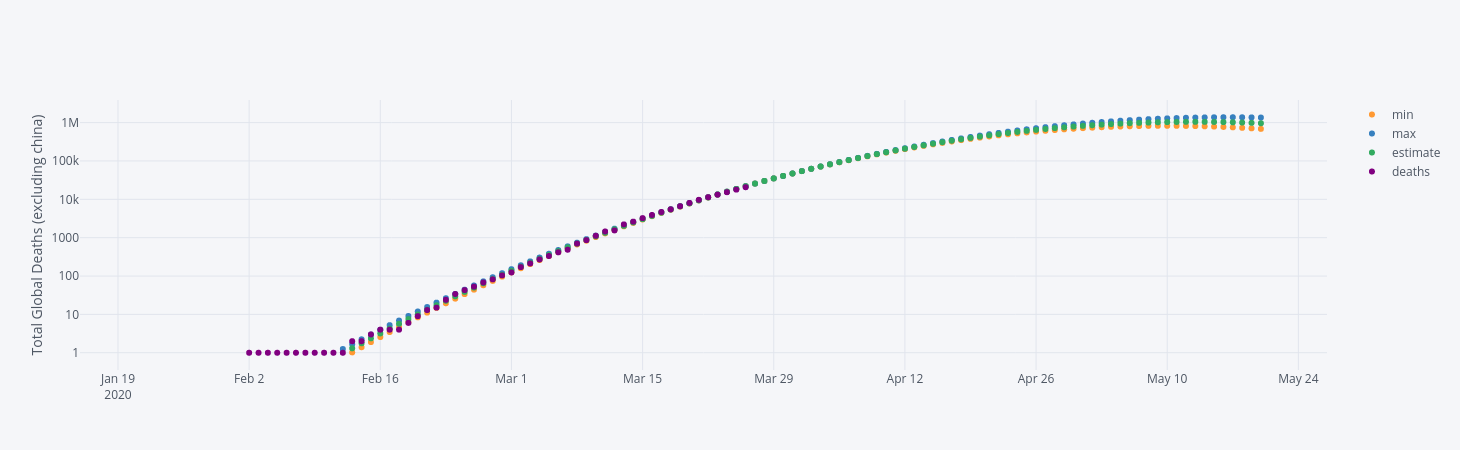

In [244]:
x0 = pd.Timestamp('today').value

category = 'deaths'
df = get_data_V2(category)
globe = get_globe(df, category, threshold=threshold_for_model[category])
x = globe['date'].astype(int)
y = globe[category]
x2 = pd.Series(pd.date_range('2020-02-10', '2020-05-20')).astype(int)

x = (x-x0)/x0
x2 = (x2-x0)/x0

coeff, cov = np.polyfit(x, y, 2, cov=True)
coeff_min = coeff - n_sigma*np.sqrt(cov).diagonal() * np.array([1, 0, 0])
coeff_max = coeff + n_sigma*np.sqrt(cov).diagonal() * np.array([1, 0, 0])

fit = pd.DataFrame(pd.date_range('2020-02-10', '2020-05-20'), columns=['date']).set_index('date')
fit['min'] = pd.np.poly1d(coeff_min)(x2)
fit['estimate'] = pd.np.poly1d(coeff)(x2)
fit['max'] = pd.np.poly1d(coeff_max)(x2)

globe = get_globe(df, category)
out = pd.concat((globe.set_index('date'), fit), axis=1)
out[out<0] = np.nan
out = out.apply(np.exp)[['min', 'max', 'estimate', category]]
out.iplot(logy=True, yTitle=f'Total Global {category.capitalize()} (excluding china)', mode='markers', size=6)


In [301]:
%%time
data = []
dates = pd.date_range('2020-02-10', '2023-05-20')
x_fit = dates.astype(int)
x_fit = (x_fit - x0)/x0

for i in range(10000):
    tmp_coeff = np.random.multivariate_normal(coeff, cov)
    fit = pd.DataFrame(dates, columns=['date']).set_index('date')
    fit['tmp'] = np.poly1d(tmp_coeff)(x_fit)
    fit.loc[fit['tmp'].diff()<0, 'tmp'] = np.nan
    fit = fit.dropna()
    data.append(fit.index.max())

CPU times: user 31.3 s, sys: 59.8 ms, total: 31.4 s
Wall time: 31.4 s


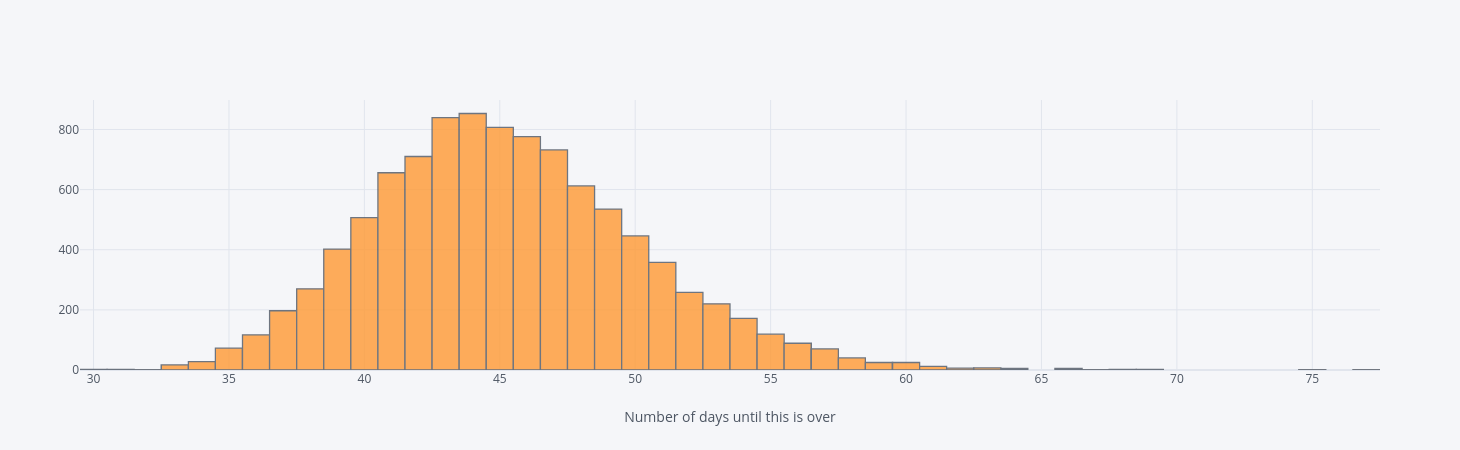

In [302]:
output = pd.DataFrame(data, columns=['date'])#.iplot(kind='hist', bins=21)
((output - pd.Timestamp('today'))['date'].dt.days).iplot(kind='hist', xTitle='Number of days until this is over')